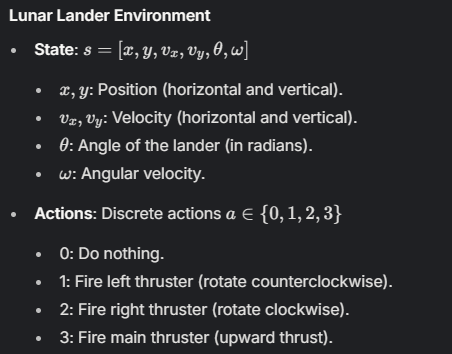

In [1]:
import numpy as np

class LunarLanderEnv:
    def __init__(self):
        self.gravity = -0.1
        self.thrust_force = 0.2
        self.torque = 0.05
        self.dt = 0.1
        self.width = 10.0
        self.height = 10.0
        self.state_dim = 6  # [x, y, vx, vy, theta, omega]
        self.action_dim = 4  # 0: nothing, 1: left, 2: right, 3: main
        self.reset()

    def reset(self):
        self.x = self.width / 2
        self.y = self.height - 1
        self.vx = 0.0
        self.vy = 0.0
        self.theta = 0.0
        self.omega = 0.0
        return np.array([self.x, self.y, self.vx, self.vy, self.theta, self.omega], dtype=np.float32)

    def step(self, action):
        # Apply forces based on action
        ax = 0.0
        ay = self.gravity
        alpha = 0.0
        
        if action == 1:  # Left thruster
            alpha = self.torque
        elif action == 2:  # Right thruster
            alpha = -self.torque
        elif action == 3:  # Main thruster
            ax = self.thrust_force * np.sin(self.theta)
            ay += self.thrust_force * np.cos(self.theta)

        # Update velocities
        self.vx += ax * self.dt
        self.vy += ay * self.dt
        self.omega += alpha * self.dt

        # Update positions
        self.x += self.vx * self.dt
        self.y += self.vy * self.dt
        self.theta += self.omega * self.dt

        # Reward and termination
        reward = -0.01
        done = False
        
        if self.y <= 0:  # Landing
            if abs(self.vy) < 0.5 and abs(self.vx) < 0.5 and abs(self.theta) < 0.2:
                reward = 1.0  # Soft landing
            else:
                reward = -1.0  # Crash
            done = True
        elif self.x < 0 or self.x > self.width or self.y > self.height:
            reward = -1.0  # Out of bounds
            done = True

        next_state = np.array([self.x, self.y, self.vx, self.vy, self.theta, self.omega], dtype=np.float32)
        return next_state, reward, done

    def render(self):
        # Simple text rendering
        print(f"Pos: ({self.x:.2f}, {self.y:.2f}), Vel: ({self.vx:.2f}, {self.vy:.2f}), Angle: {self.theta:.2f}, Omega: {self.omega:.2f}")

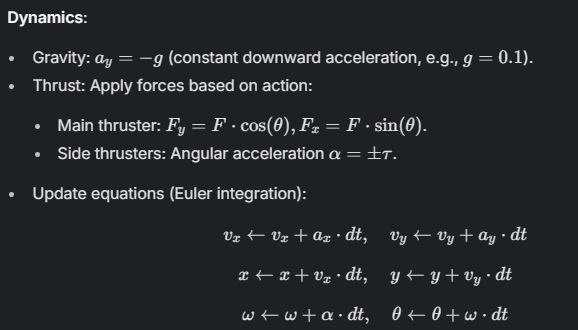

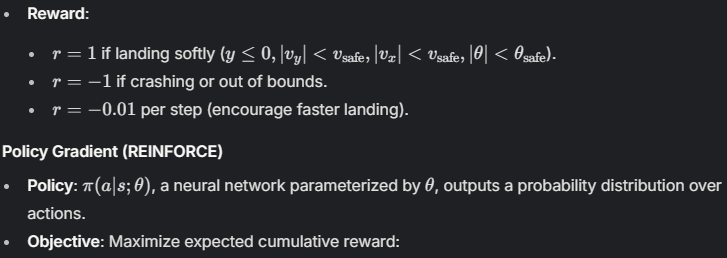

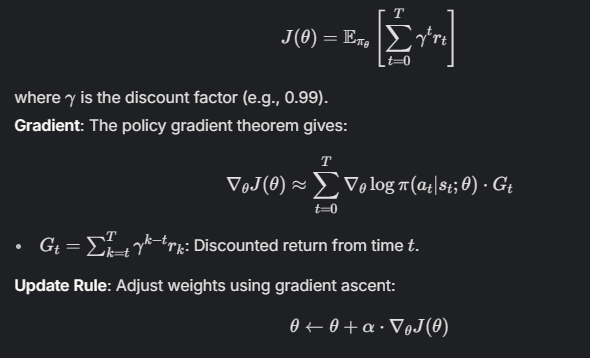

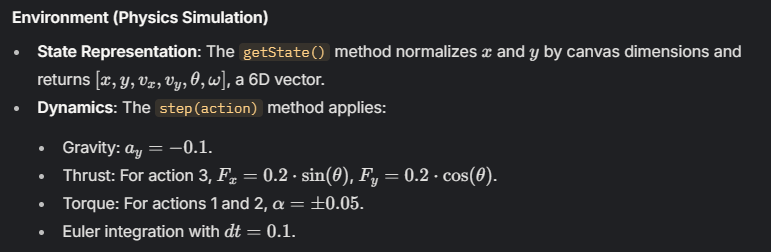

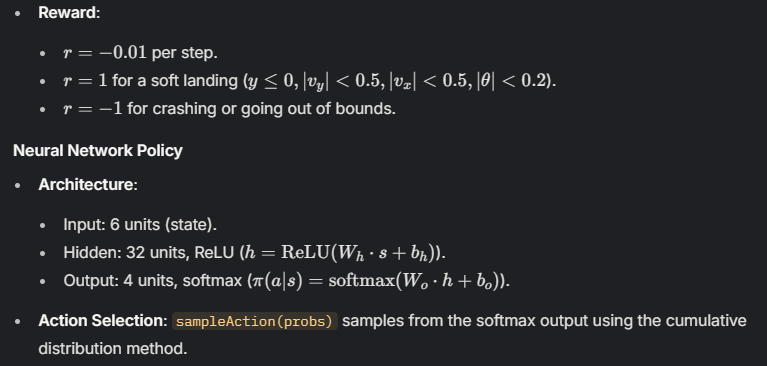

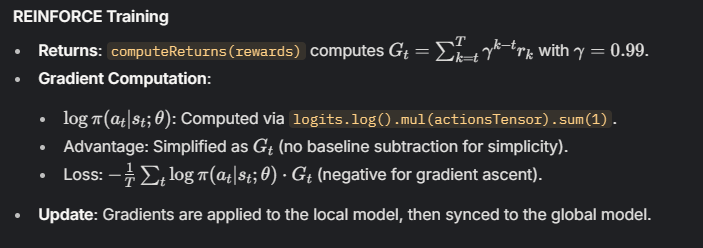

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.uint8)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, buffer_capacity, batch_size, target_update_freq, device="cpu"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.device = device

        self.q_network = QNetwork(state_dim, action_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

        self.update_target_network()
        self.train_step = 0

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def learn(self):
        if len(self.buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)

        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.long).unsqueeze(1).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.uint8).unsqueeze(1).to(self.device)

        q_values = self.q_network(state).gather(1, action)
        next_q_values = self.target_network(next_state).max(1)[0].unsqueeze(1)
        target_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()

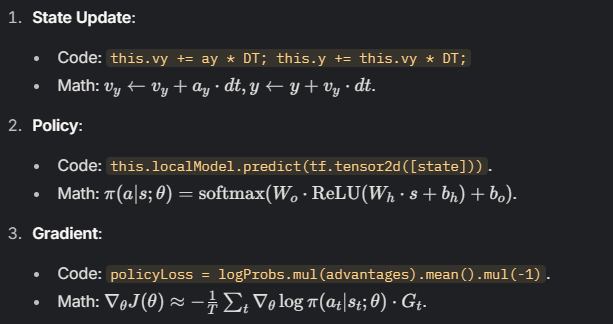

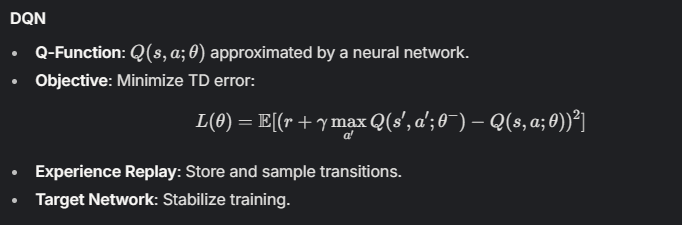